# UQ for G and h

In [11]:
import pandas as pd
import numpy as np
from methods import binomial_method, random_effects_dl, random_effects_hksj, birge
import matplotlib.pyplot as plt
from scipy.stats import norm, t

plt.rc("text", usetex=True)

In [2]:
# Gravitational Constant
g_df = pd.read_csv("data/G.csv")
g_df

,id,value,sigma
0,NIST-82,6.672480,0.000430
1,TR\&D-96,6.672900,0.000500
2,LANL-97,6.673980,0.000700
3,UWash-00,6.674255,0.000092
4,BIPM-01,6.675590,0.000270
5,UWup-02,6.674220,0.000980
6,MSL-03,6.673870,0.000270
7,HUST-05,6.672220,0.000870
8,UZur-06,6.674250,0.000120
9,HUST-09,6.673490,0.000180


In [4]:
# Planck Constant
h_df = pd.read_csv("data/h.csv")
h_df

,id,value,sigma
0,IAC-11,6.626070,2.000000e-07
1,NIST-07,6.626069,2.400000e-07
2,NIST-98,6.626069,5.800000e-07
3,NPL-90,6.626068,1.300000e-06
4,NPL-12,6.626071,1.300000e-06
5,METAS-11,6.626069,2.000000e-06
6,NMI-89,6.626068,3.600000e-06
7,PTB-91,6.626067,4.200000e-06
8,NPL-79,6.626073,6.700000e-06
9,NIST-80,6.626066,8.800000e-06


In [5]:
# define datasets
datasets = {
    "G": {
        "values": np.array(g_df["value"]),
        "uncertainties": np.array(g_df["sigma"]),
        "names": g_df["id"],
        "xlabel": "Gravitational constant $G$ [10$^{-11}$ m$^3$ kg$^{-1}$ s$^{-2}$]",
        "codata_value": 6.67430,
        "codata_sigma": 0.00015,
    },
    "h": {
        "values": np.array(h_df["value"]),
        "uncertainties": np.array(h_df["sigma"]),
        "names": h_df["id"],
        "xlabel": "Planck constant $h$ [J s]",
        "codata_value": 6.62606957,
        "codata_sigma": 0.00000029,
    },
}

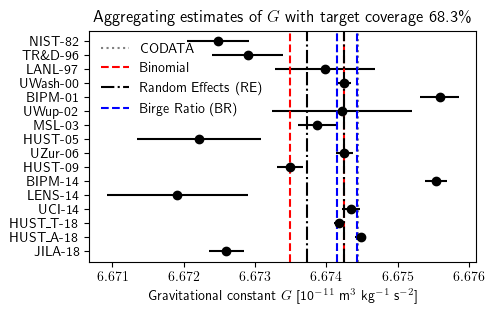

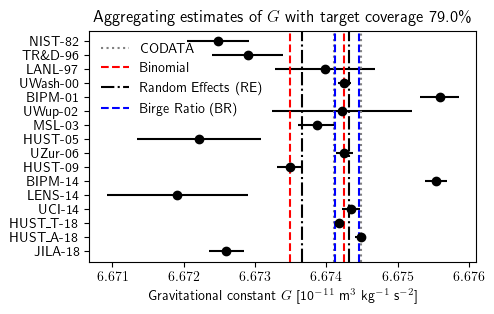

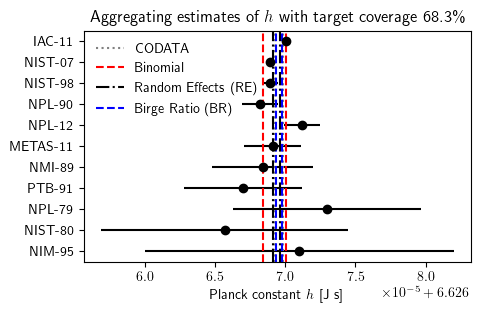

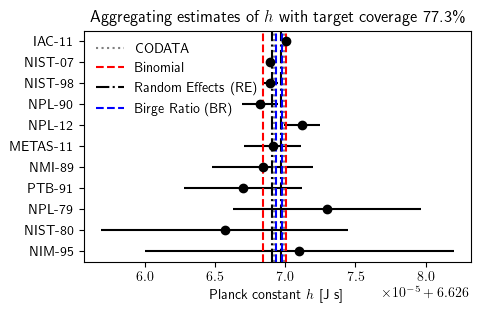

In [ ]:
for var, d in datasets.items():
    values = d["values"]
    uncertainties = d["uncertainties"]
    names = d["names"]
    # plot figure of the dataframe values and corresponding intervals
    # so that each value and interval is in one row
    n = len(values)
    p = 0.5

    for i in range(2):
        plt.figure(figsize=(5, 3))
        plt.errorbar(values, -np.arange(n), xerr=uncertainties, fmt="o", color="black")
        plt.yticks(-np.arange(n), names)

        target = 0.6827
        tail_prob = (1 - target) / 2

        lower, tail_prob_achieved = binomial_method(
            np.sort(values), p=p, target=tail_prob, which="lower"
        )
        upper, _ = binomial_method(
            np.sort(values), p=p, target=tail_prob, which="upper"
        )

        interval_binomial = [lower, upper]

        if i == 0:
            z_alpha = norm.ppf(1 - tail_prob)
            t_alpha = t.ppf(1 - tail_prob, n - 1)
            target_cov = 1 - (2 * tail_prob)
        else:
            z_alpha = norm.ppf(1 - tail_prob_achieved)
            t_alpha = t.ppf(1 - tail_prob_achieved, n - 1)
            target_cov = 1 - (2 * tail_prob_achieved)

        # calculate using random-effects model (DL)
        interval_re_dl, muhat, sigma, _ = random_effects_dl(
            values, uncertainties, zalpha=z_alpha
        )

        # calculate using random-effects model (HKSJ)
        interval_re_hksj, muhat, sigma, _ = random_effects_hksj(
            values, uncertainties, talpha=t_alpha
        )

        # calculate using Birge ratio
        interval_birge, muhat, sigma, _ = birge(values, uncertainties, zalpha=z_alpha)

        # CODATA
        muhat, sigma = d["codata_value"], d["codata_sigma"]
        interval_codata = [muhat - sigma * z_alpha, muhat + sigma * z_alpha]

        plt.axvline(interval_codata[0], color="grey", linestyle=":", label="CODATA")
        plt.axvline(interval_codata[1], color="grey", linestyle=":")

        plt.axvline(interval_binomial[0], color="red", linestyle="--", label="Binomial")
        plt.axvline(interval_binomial[1], color="red", linestyle="--")

        plt.axvline(
            interval_re_hksj[0],
            color="black",
            linestyle="-.",
            label="Random Effects (RE)",
        )
        plt.axvline(interval_re_hksj[1], color="black", linestyle="-.")

        plt.axvline(
            interval_birge[0], color="blue", linestyle="--", label="Birge Ratio (BR)"
        )
        plt.axvline(interval_birge[1], color="blue", linestyle="--")

        plt.legend(frameon=False, loc="upper left")

        plt.xlabel(d["xlabel"])
        plt.title(
            rf"Aggregating estimates of ${var}$ with target coverage {np.round(target_cov*100, 1)}\%"
        )

        plt.savefig(f"figs/{var}{i}.pdf", bbox_inches="tight")
        plt.show()